<a href="https://colab.research.google.com/github/raja-azlina/DGA_Detection/blob/master/detect_3dictionary_dgas-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect Benign, Gozi, Matsnu and Suppobox using Gaussian Mixture Models (GMM)

In [2]:
# for tasks
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture

# auxiliary analysis and evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score

# for visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["xaxis.labellocation"] = "right"
plt.rcParams["yaxis.labellocation"] = "top"
colors = ['#274E7A', '#5C8473', '#645A7E', '#24242E', '#DE4F1F']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)


## 1. Feature Engineering

Let's take a look at a dataset of dgas in my hard drive, e.g. merged-40k-no1, location in data-dga-merged directory

This dataset has 2 columns, only domain and label.
Later, we need to get the ones with the features, not trim ones,
we will only focus on FEW TOP features.  

ORIGINAL OBJECTIVE -- NOTE: am not sure if I could get this.  In my case, I should have 4 distributions.

*******
I am most interested in taking a look at the quantity of books column as it has bimodal distribution.

The goal here is to use GMM in order to generate two normally distributed features from the bimodal Quantity column.
*******

In [3]:
#load book dataset from drive - merged-40k-no1

from google.colab import files
uploaded = files.upload()

Saving file40k-42cols.csv to file40k-42cols.csv


In [4]:

# load dataset
df = pd.read_csv('file40k-42cols.csv')
#df = pd.read_csv('trim-matsnu-10000-4.csv')

# create a GMM model with 4 components (one for each mode in our distribution)
gmm = GaussianMixture(n_components=4)
#gmm.fit(df[['label']])  #column name for merge file with domain and label
gmm.fit(df[['41']]) #column 42th or column number [41]

# predict component for the feature
df['component'] = gmm.predict(df[['41']])
#df['component'] = gmm.predict(df[['label']])


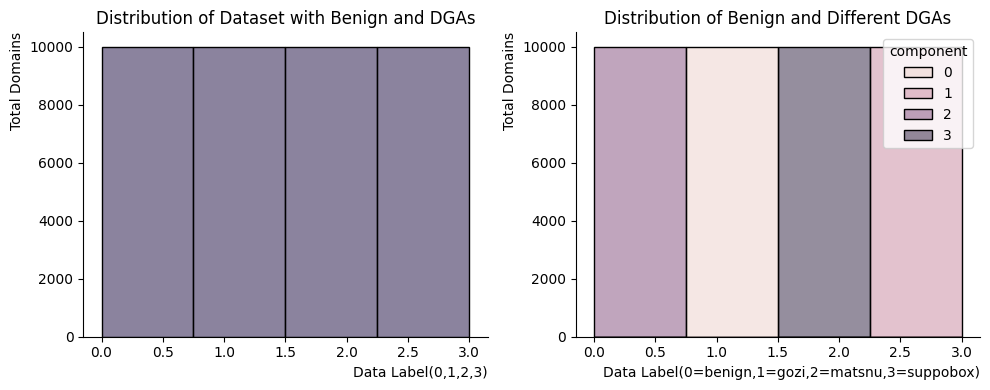

In [5]:
fig, (before, after) = plt.subplots(ncols=2, figsize=(10, 4))

# plot histogram for a feature of interest:
sns.histplot(data=df, x='41', bins=4, ax=before, color=colors[2])
sns.despine()
before.set_xlabel("Data Label(0,1,2,3)")
before.set_ylabel("Total Domains")
before.title.set_text("Distribution of Dataset with Benign and DGAs")

# plot histogram, showing two components
sns.histplot(data=df, x='41', bins= 4, hue='component', ax=after)
sns.despine()
after.set_xlabel("Data Label(0=benign,1=gozi,2=matsnu,3=suppobox)")
after.set_ylabel("Total Domains")
after.title.set_text("Distribution of Benign and Different DGAs")

#does not work
#plt.xticks(np.linspace(start=0, stop=4, num=4))
plt.tight_layout()
plt.show()

## 2. Unsupervised Classification

In [6]:
# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

#!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
#!unzip palmer-archipelago-antarctica-penguin-data

# load the dataset
df = pd.read_csv('file40k-42cols.csv')

# remove null values
df = df[~df.isnull().any(axis=1)]
df = df.reset_index(drop=True)

# select features
features = ['13', '0']

# create a model with 4 components/classes
gmm = GaussianMixture(n_components=4)
gmm.fit(df[features])

# predict components and probabilities
components = gmm.predict(df[features])
probabilities = gmm.predict_proba(df[features])


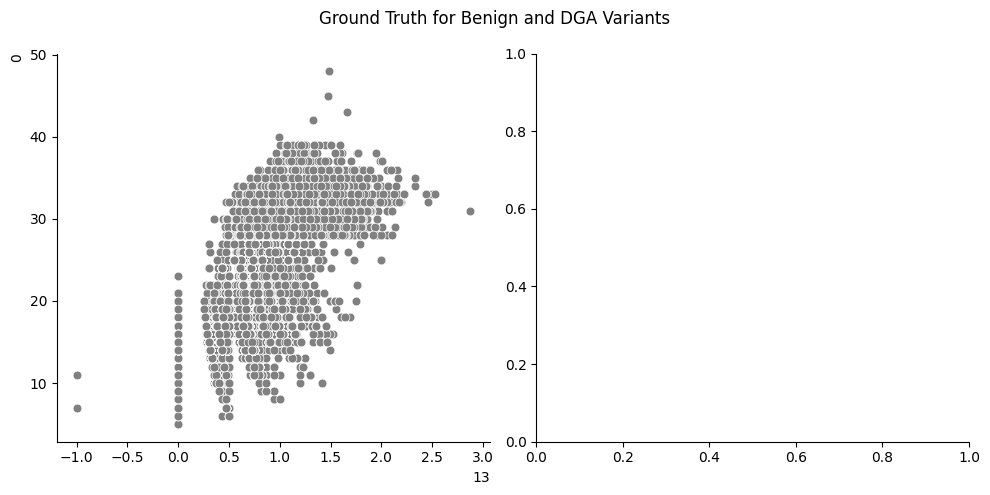

In [15]:
# plot a scatterplot of culment length vs. depth and colorcode species
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=df, x='13', y='0', color='gray', s=40, ax=axes[0])


sns.scatterplot(data=df, x='13', y='0', hue='41', s=40, ax=axes[1])
sns.despine()

plt.suptitle('Ground Truth for Benign and DGA Variants')
plt.tight_layout()
plt.show()

<ipython-input-13-c93f91ca25ad>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='13', y='0', hue='41', s=40, ax=axes[1],palette=palette)


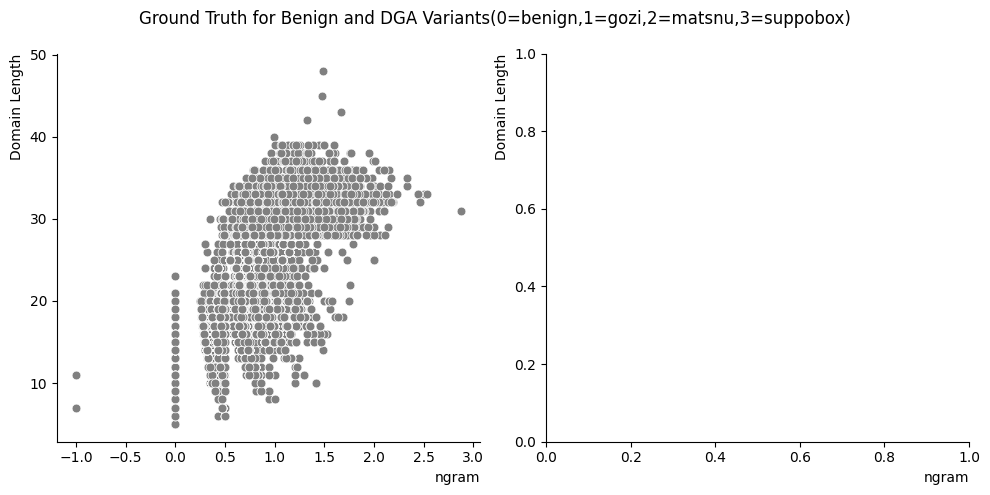

In [13]:
# plot a scatterplot of culment length vs. depth and colorcode species
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))


sns.scatterplot(data=df, x='13', y='0', color='gray', s=40, ax=axes[0])
axes[0].set_xlabel("ngram")
axes[0].set_ylabel("Domain Length")

#add this for axes[1]
#df['41'] = df['41'].map({'0':'benign','1':'gozi','2':'matsnu','3':'suppobox'})

#####not working  -- no plot
#df['41'] = df['41'].map({'benign':'0','gozi':'1','matsnu':'2','suppobox':'3'})  #rename the hue values
#palette = {'benign': 'cornflowerblue', 'gozi': 'fuchsia', 'matsnu': 'limegreen', 'suppobox':'turquoise'}

palette = {'0':'cornflowerblue', '1':'fuchsia', '2':'limegreen', '3':'turquoise'}
sns.scatterplot(data=df, x='13', y='0', hue='41', s=40, ax=axes[1],palette=palette)
axes[1].set_xlabel("ngram")
axes[1].set_ylabel("Domain Length")

sns.despine()


plt.suptitle('Ground Truth for Benign and DGA Variants(0=benign,1=gozi,2=matsnu,3=suppobox)')
plt.tight_layout()
plt.show()

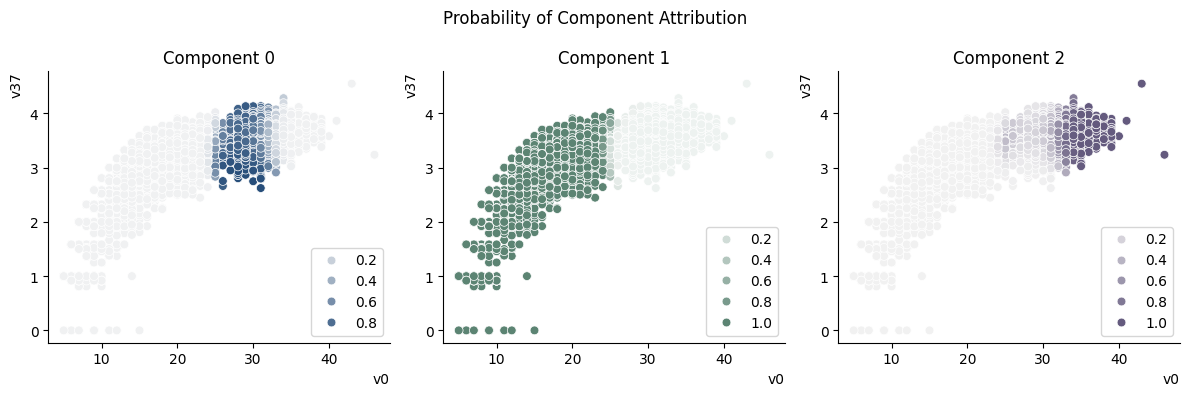

In [ ]:
fix, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i in range(3):

    proba_component_i = gmm.predict_proba(df[features])[:, i]
    category_color = sns.color_palette('light:%s' % colors[i], as_cmap=True)
    sns.scatterplot(data=df, x='v0', y='v37', s=40,
                    hue=proba_component_i, palette=category_color, legend='brief',
                    ax=axes[i])
    axes[i].set_title('Component %d' % i)
    sns.despine()

plt.suptitle('Probability of Component Attribution')
plt.tight_layout()
plt.show()

## 3. Anomaly Detection

In [ ]:
#load book dataset from drive - wine

from google.colab import files
uploaded = files.upload()

Saving wine.mat to wine.mat


In [ ]:
# upload the datafile
# http://odds.cs.stonybrook.edu/wine-dataset/
# Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.
#wine = loadmat('wine.mat')

# grab the features and create a dataframe
'''columns = ["alcohol", "malicacid", "ash", "alcalinity_of_ash", "magnesium",
          "total_phenols", "flavanoids", "nonflanoid_phenols", "proanthocyanins",
          "color_intensity", "hue", "0D280_0D315_of_diluted_wines", "proline"]

print('Total features:', len(columns))

df = pd.DataFrame(wine["X"], columns=columns)

'''

# load the dataset
df = pd.read_csv('trim-matsnu-10000-4.csv')

print(df.shape)


# anomaly targets
y_true = df["result"]

# fit the model with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(df)

# get predicted data
component = gmm.predict(df)
proba = gmm.predict_proba(df)


(20001, 26)


Explained variance ratio: [9.99997133e-01 2.77471833e-06]


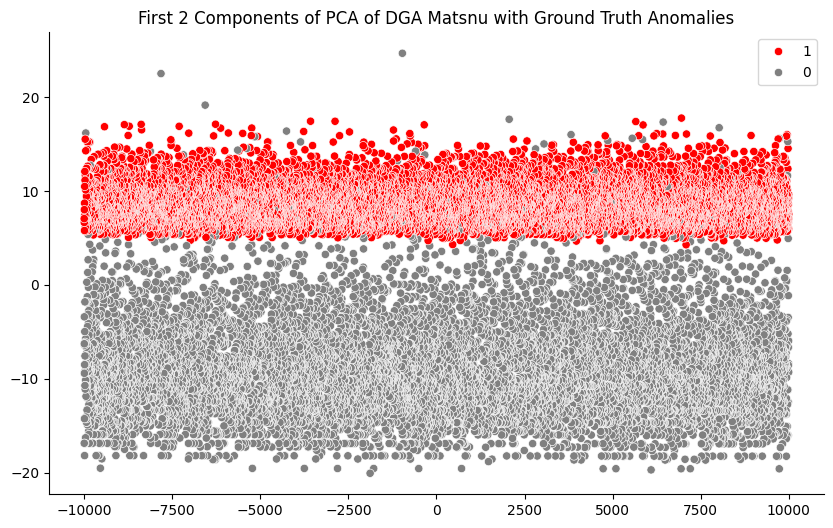

In [ ]:
# create PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df)
print('Explained variance ratio:', pca.explained_variance_ratio_)

# show as scatterplot
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1],
                hue=np.where(y_true==1, '1', '0'),
                palette=sns.color_palette(['r', 'gray'], as_cmap=True))
sns.despine()
plt.title('First 2 Components of PCA of DGA Matsnu with Ground Truth Anomalies')
plt.show()

In [ ]:
# in ground truth, 1 is anomaly
# gmm randomizes component index so we should align our ground truth with predicted values
# if predicted component 1 is positive, switch 1 and 0 components to align with 1 being anomaly
if sum(component) >= len(component)/2:
    component = -1*(component-1)
    proba = proba[:,[1,0]]


# put together confusion matrix
cm = pd.DataFrame(confusion_matrix(y_true, component),
                  columns=['Predicted Positive', 'Predicted Anomaly'],
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                 9010 │                 990 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                 9459 │                 542 │
╘═══════════════╧══════════════════════╧═════════════════════╛


In [ ]:
print('F1 Score:', f1_score(y_true, component))

F1 Score: 0.6451612903225806


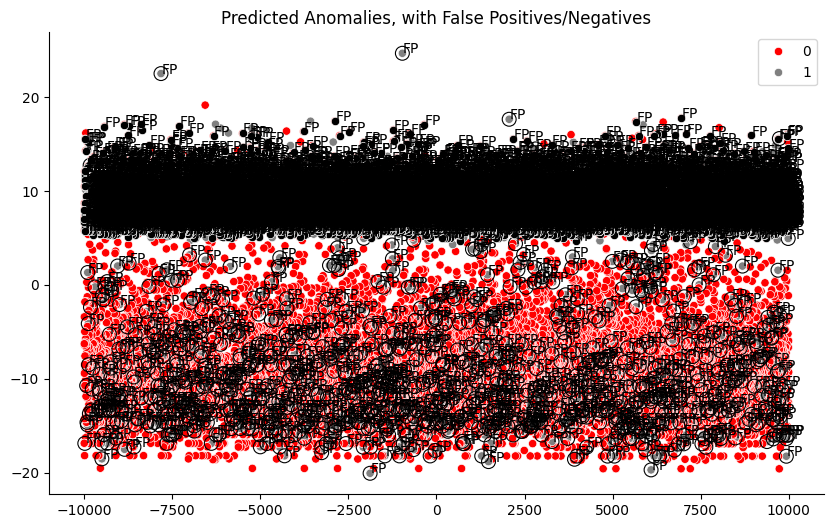

In [ ]:
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=np.where(component==1, '1', '0'),
                palette=sns.color_palette(['red', 'gray'], as_cmap=True))

# plot and annotate false positives
pca_components_FP = pca_components[(y_true==0)&(component==1), :]
sns.scatterplot(x=pca_components_FP[:, 0], y=pca_components_FP[:, 1], color='black', fc='none', ec='black', s=100)

for i in range(len(pca_components_FP)):
    plt.annotate("FP", (pca_components_FP[-(i+1), 0]+10, pca_components_FP[-(i+1), 1]))

# plot and annotate false negatives
pca_components_FN = pca_components[(y_true==1)&(component==0), :]
sns.scatterplot(x=pca_components_FN[:, 0], y=pca_components_FN[:, 1], color='black')

for i in range(len(pca_components_FN)):
    plt.annotate("FP", (pca_components_FN[-(i+1), 0]+10, pca_components_FN[-(i+1), 1]))

sns.despine()
plt.title('Predicted Anomalies, with False Positives/Negatives')
plt.show()

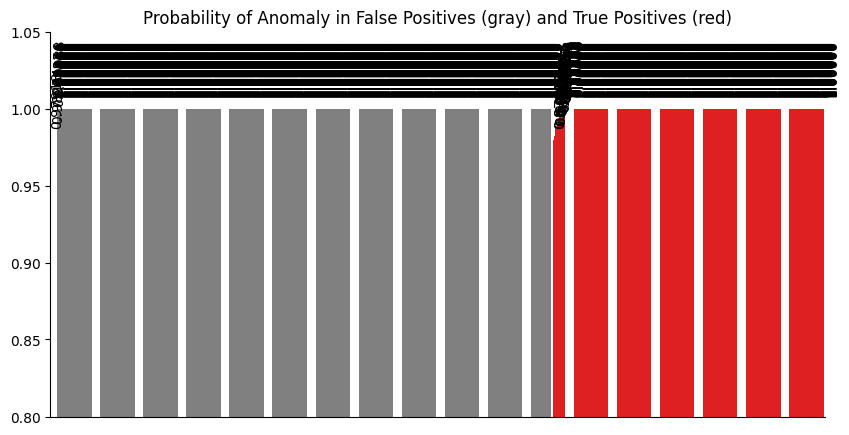

In [ ]:
plt.figure(figsize=(10, 5))

proba_FP = proba[(y_true==0)&(component==1), 1]
proba_FP.sort()
proba_TP = proba[(y_true==1)&(component==1), 1]
proba_TP.sort()
proba_analysis = np.concatenate([proba_FP, proba_TP])
type = ['fp'] * len(proba_FP) + ['tp'] * len(proba_TP)
x = list(range(len(proba_analysis)))

ax = sns.barplot(x=x, y=proba_analysis, dodge=False,
                 hue=type, palette=sns.color_palette(['gray', 'red'], as_cmap=True))

for i, val in enumerate(list(proba_analysis)):
    plt.annotate('%.5f' % val, (i-0.2, val+0.01), rotation=90)

ax.set_ybound(0.8, 1.05)
plt.xticks([])
sns.despine()
plt.title('Probability of Anomaly in False Positives (gray) and True Positives (red)')
plt.legend().remove()
plt.show()

In [ ]:
# create new components based on the probability analysis
component_fixed = np.where(proba[:, 1]>0.99999, 1, 0)

In [ ]:
# put together confusion matrix
cm = pd.DataFrame(confusion_matrix(y_true, component_fixed),
                  columns=['Predicted Positive', 'Predicted Anomaly'],
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                 9015 │                 985 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                 9501 │                 500 │
╘═══════════════╧══════════════════════╧═════════════════════╛


In [ ]:
print('F1 Score:', f1_score(y_true, component_fixed))

F1 Score: 0.08706251088281386


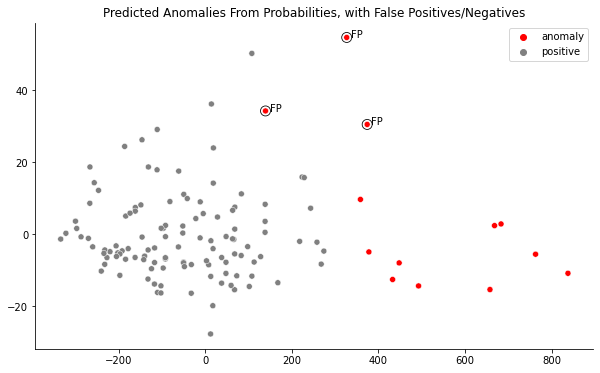

In [ ]:
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=np.where(component_fixed==1, 'anomaly', 'positive'),
                palette=sns.color_palette(['red', 'gray'], as_cmap=True))

# plot and annotate false positives
pca_components_FP = pca_components[(y_true==0)&(component_fixed==1), :]
sns.scatterplot(x=pca_components_FP[:, 0], y=pca_components_FP[:, 1], color='black', fc='none', ec='black', s=100)

for i in range(len(pca_components_FP)):
    plt.annotate("FP", (pca_components_FP[-(i+1), 0]+10, pca_components_FP[-(i+1), 1]))

# plot and annotate false negatives
pca_components_FN = pca_components[(y_true==1)&(component_fixed==0), :]
sns.scatterplot(x=pca_components_FN[:, 0], y=pca_components_FN[:, 1], color='black')

for i in range(len(pca_components_FN)):
    plt.annotate("FP", (pca_components_FN[-(i+1), 0]+10, pca_components_FN[-(i+1), 1]))

sns.despine()
plt.title('Predicted Anomalies From Probabilities, with False Positives/Negatives')
plt.show()